# Чистка набора данных по скважине 1044

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## 1. Определение периодов работы скважины через замерной сепаратор

In [ ]:
df = pd.read_csv('data/well-selected.txt', # открываем нужный файл
                 sep='	', # выбираем разделитель в файле
                 header=None, # нет встроенных заголовков
                 names=['date', 'well'], # сами задаем загаловки столбцов
                 skiprows = 4, # пропускаем 4 строки служебной информации
                 index_col = 'date', # задаем индексы для строк по времени замера
                 parse_dates = True) # приводим к формату datetimeindex

In [3]:
well = '1044' # выбираем нужную скважину
df.loc[df['well'] != well, 'well'] = np.nan # заменяем на NaN все, что не 1044
df['well'] = pd.to_numeric(df['well']) # перевод в числовой формат для дальнейшей интерполяции
dfa = pd.DataFrame(index = pd.date_range(start='2016-01-01', end='2020-01-01',  freq='30T')) # создаем датафрейм с фиксированной периодичностью datetimeindex
df = pd.concat([df, dfa]) # объединение исходного датафрейма с новым
df.sort_index(inplace=True) # сортируем

,well
2016-01-01 00:00:00,NaN
2016-01-01 00:16:04,NaN
2016-01-01 00:30:00,NaN
2016-01-01 00:46:04,NaN
2016-01-01 01:00:00,NaN


In [4]:
%%time
# заполнение пропусков
well = 1044
tmp = 0 # переменная нахождения
tm = 0 # переменная повтора nan
print('Было всего:', len(df))
for row in range(len(df)): # итерация по численным индексам датафрейма
    if tmp == 1 and np.isnan(df.iloc[row, 0]): # если после 1044 идет пустота
        tmp = 2 # меняем переменную на 2
        tm = 0 # сброс переменной nan
    elif tmp == 2 and df.iloc[row, 0] == well: # если после пустоты снова 1044
        tmp = 0 # сбрасываем переменную для последующего поиска пропусков
        df.iloc[row-1, 0] = well # меняем пустоту на 1044
        tm = 0 # сброс переменной nan
    if df.iloc[row, 0] == well: # проваливаемся сюда при первой встрече с 1044
        tmp = 1 # меняем переменную на 1
    if np.isnan(df.iloc[row, 0]): # проваливаемся, когда видим nan
        tm += 1
        if tm > 1: # проваливаемся, когда видим повторный nan
            tmp = 0 # сброс переменной фильтра
df = df.dropna() # удаляем пропуски в данных
dfm = pd.DataFrame() # создаем итоговый датафрейм
dfm["1044"] = "" # добавление столбца
for row in df.itertuples(): # итерация по объединенному датафрейму
    if row[0] in dfa.index: # проверяем, есть ли индекс
        dfm.loc[row[0]] = [row[1]] # добавление новой записи в датафрейм dfm
del dfm['1044'] # удаление лишнего столбца
print('Осталось:', len(dfm))
dfm.head(5)

Было всего: 154940
Осталось: 6371
Wall time: 1min 15s


""
2016-01-05 10:30:00
2016-01-05 11:00:00
2016-01-05 11:30:00
2016-01-05 12:00:00
2016-01-05 12:30:00


## 2. Обработка данных по давлению и температуре

Набор признаков по скважине 1044:
- P1 — давление на устье (PIT 9001)
- T1 — температура на устье (TIT 9001)
- P2 — давление до дросселя (PIT 5001)
- T2 — температура до дросселя (TIT 5001)
- P3 — давление после дросселя (PIT 5003)
- T3 — температура после дросселя (TIT 5003)

In [5]:
directory = 'data/'

In [6]:
wn = '1044'

In [7]:
well = {
    'P1' : 'PT-1044_01',
    'P2' : 'PT-1044_02',
    'P3' : 'PT-1044_03',
    'T1' : 'TT-1044_01',
    'T2' : 'TT-1044_02',
    'T3' : 'TT-1044_03',
    'TA' : 'T-AIR',
    'TG' : 'T-GRO',
    'PO' : 'PIT-5173'
}

В цикле разбавлять все временные датафреймы эталонным, сразу же интерполировать. Далее работать с двумя версиями

In [8]:
%%time
dfa = pd.DataFrame(index = pd.date_range(start='2016-01-01', end='2020-01-01',  freq='30T')) # создаем датафрейм с фиксированной периодичностью datetimeindex
#df_main = pd.DataFrame(index = pd.date_range(start='2016-01-01', end='2020-01-01',  freq='30T')) # создаем датафрейм с фиксированной периодичностью datetimeindex
for key, parameter in well.items():
    df = pd.read_csv(directory + parameter + '.txt',
                     sep='	',
                     header=None,
                     names=['date', key],
                     skiprows = 4,
                     index_col = 'date',
                     parse_dates = True)
    df[key] = pd.to_numeric(df[key], errors='coerce') # формат числа, все ошибки в NaN
    print(df.isnull().sum().sum(), ' значений признака ' + key + ' являются сообщениями об ошибках.')
    print(round(df.isnull().sum().sum() / len(df) * 100, 2), '% данных удалено\n')
    df = pd.concat([dfa, df])
    df.sort_index(inplace=True)
    df.interpolate(method='time', limit=4, inplace=True) # интерполируем inplace методом time с лимитом в 4 пропуска
    dfm[key] = "" # добавление столбца температуры
    for row in df.itertuples(): # итерация по объединенному датафрейму
        if row[0] in dfm.index: # проверяем, есть ли индекс
            dfm.at[row[0], key] = row[1] # добавление новой записи в датафрейм dfm

4899  значений признака P1 являются сообщениями об ошибках.
5.55 % данных удалено

3999  значений признака P2 являются сообщениями об ошибках.
4.56 % данных удалено

3995  значений признака P3 являются сообщениями об ошибках.
4.59 % данных удалено

4898  значений признака T1 являются сообщениями об ошибках.
5.55 % данных удалено

3978  значений признака T2 являются сообщениями об ошибках.
4.56 % данных удалено

3976  значений признака T3 являются сообщениями об ошибках.
4.55 % данных удалено

3936  значений признака TA являются сообщениями об ошибках.
3.17 % данных удалено

3974  значений признака TG являются сообщениями об ошибках.
4.57 % данных удалено

3979  значений признака PO являются сообщениями об ошибках.
4.55 % данных удалено

Wall time: 5min 49s


In [9]:
dfm.head()

,P1,P2,P3,T1,T2,T3,TA,TG,PO
2016-01-05 10:30:00,7.4981,7.30198,5.38889,64.2378,41.6679,34.001,2.9842,12.0951,5.31105
2016-01-05 11:00:00,7.4901,7.29209,5.3732,64.2521,41.6937,33.9013,3.53249,12.095,5.29523
2016-01-05 11:30:00,7.49806,7.30016,5.37941,64.261,41.742,33.9834,4.731,12.0974,5.30149
2016-01-05 12:00:00,7.50444,7.30911,5.38383,64.2697,41.7581,34.0899,5.81058,12.0925,5.30511
2016-01-05 12:30:00,7.49183,7.29572,5.37754,64.3452,41.7429,34.0421,6.23234,12.0887,5.29826


In [10]:
dfm.describe()

,P1,P2,P3,T1,T2,T3,TA,TG,PO
count,6361.000000,6371.00000,6370.0,6361.000000,6371.000,6371.000,6371.000000,6371.000000,6371.000000
unique,6361.000000,6363.00000,6224.0,6361.000000,6361.000,6361.000,6366.000000,6371.000000,6371.000000
top,5.030818,-0.68875,-3.0,63.476112,-45.075,-45.075,5.215908,15.202532,5.478378
freq,1.000000,9.00000,8.0,1.000000,11.000,11.000,2.000000,1.000000,1.000000


In [11]:
dfm = dfm.astype(float)

In [12]:
dfm.describe()

,P1,P2,P3,T1,T2,T3,TA,TG,PO
count,6361.000000,6371.000000,6370.000000,6361.000000,6371.000000,6371.000000,6371.000000,6371.000000,6371.000000
mean,5.991131,5.769553,5.212559,59.268908,36.166737,33.840677,17.133270,21.015628,5.184285
std,0.837384,0.856366,0.453782,4.527135,6.816311,6.763714,11.786317,7.906744,0.340270
min,0.028570,-0.688750,-3.000000,13.241736,-45.075000,-45.075000,-14.542944,7.553524,4.482373
25%,5.399256,5.169383,4.941781,56.314787,31.257396,29.639095,7.714996,13.207443,4.898852
50%,5.700443,5.509640,5.256194,59.403683,36.555047,34.606045,16.594944,21.157496,5.221759
75%,6.739019,6.536315,5.497738,63.199233,41.656453,38.195729,27.057134,28.231575,5.442308
max,8.203495,8.083053,6.306673,65.748098,45.864090,45.752886,41.776329,33.428279,6.314316


In [13]:
dfm.isna().sum()

P1    10
P2     0
P3     1
T1    10
T2     0
T3     0
TA     0
TG     0
PO     0
dtype: int64

In [14]:
dfm.dropna(inplace=True)

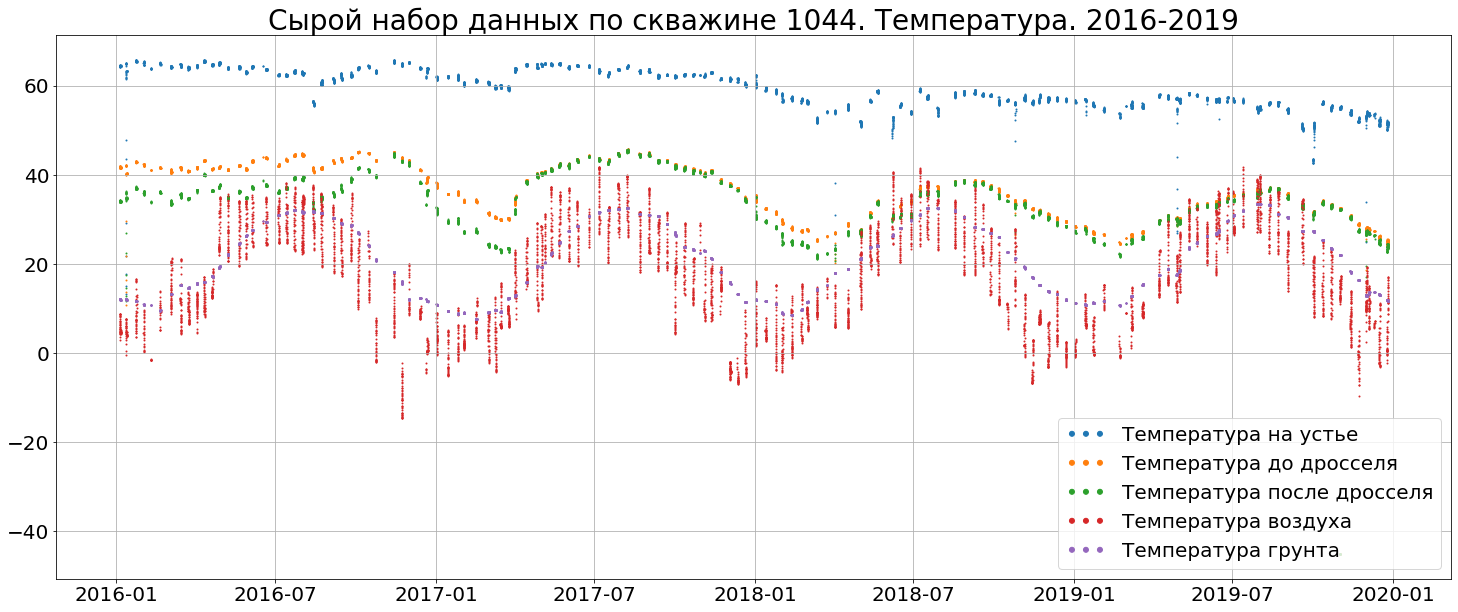

In [15]:
parameter1 = 'T1'
parameter2 = 'T2'
parameter3 = 'T3'
parameter4 = 'TA'
parameter5 = 'TG'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Температура на устье')
y = dfm[[parameter2]]
plt.scatter(x, y, s=1, label='Температура до дросселя')
y = dfm[[parameter3]]
plt.scatter(x, y, s=1, label='Температура после дросселя')
y = dfm[[parameter4]]
plt.scatter(x, y, s=1, label='Температура воздуха')
y = dfm[[parameter5]]
plt.scatter(x, y, s=1, label='Температура грунта')
plt.title('Сырой набор данных по скважине ' + wn + '. Температура. 2016-2019', fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/start_' + wn + '_temp.jpeg', dpi=300)

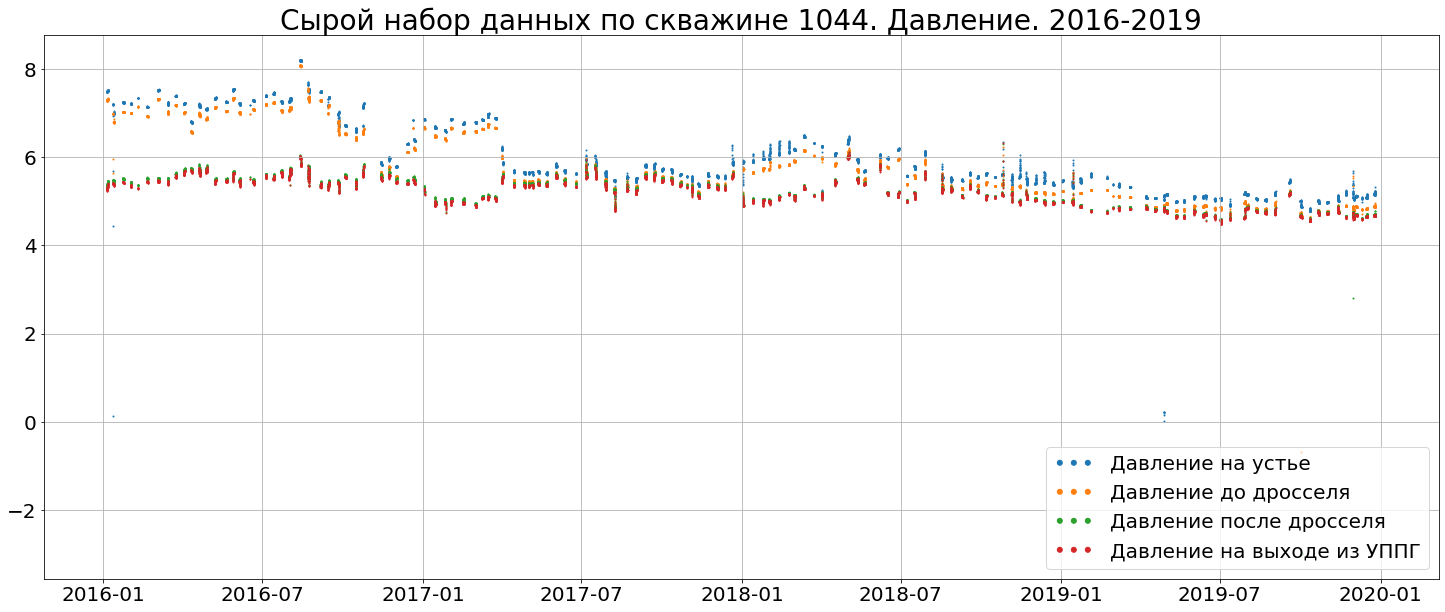

In [16]:
parameter1 = 'P1'
parameter2 = 'P2'
parameter3 = 'P3'
parameter4 = 'PO'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Давление на устье')
y = dfm[[parameter2]]
plt.scatter(x, y, s=1, label='Давление до дросселя')
y = dfm[[parameter3]]
plt.scatter(x, y, s=1, label='Давление после дросселя')
y = dfm[[parameter4]]
plt.scatter(x, y, s=1, label='Давление на выходе из УППГ')
plt.title('Сырой набор данных по скважине ' + wn + '. Давление. 2016-2019', fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/start_' + wn + '_press.jpeg', dpi=300)

In [17]:
dfm.describe()

,P1,P2,P3,T1,T2,T3,TA,TG,PO
count,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000
mean,5.991284,5.770856,5.213030,59.269100,36.167882,33.838740,17.121031,21.005226,5.184827
std,0.837361,0.856376,0.453832,4.527465,6.821774,6.769140,11.790863,7.908816,0.340100
min,0.028570,-0.688750,-3.000000,13.241736,-45.075000,-45.075000,-14.542944,7.553524,4.482373
25%,5.400626,5.169792,4.942048,56.314462,31.248566,29.633800,7.698884,13.206356,4.899616
50%,5.700604,5.510602,5.258108,59.406379,36.555274,34.608096,16.571080,21.156900,5.222800
75%,6.740626,6.538565,5.497906,63.199664,41.663200,38.197760,27.056986,28.232092,5.442419
max,8.203495,8.083053,6.306673,65.748098,45.864090,45.752886,41.776329,33.428279,6.314316


In [18]:
# Диапазон значений для температуры на устье
dfm = dfm[~(dfm.T1 > 75)]
dfm = dfm[~(dfm.T1 < 40)]

# Диапазон значений для температуры до дросселя
dfm = dfm[~(dfm.T2 > 50)]
dfm = dfm[~(dfm.T2 < 15)]

# Диапазон значений для температуры после дросселя
dfm = dfm[~(dfm.T3 > 50)]
dfm = dfm[~(dfm.T3 < 15)]

In [19]:
# Диапазон значений для температуры на устье
dfm = dfm[~(dfm.P1 < 4)]

# Диапазон значений для температуры до дросселя
dfm = dfm[~(dfm.P2 < 4)]

# Диапазон значений для температуры после дросселя
dfm = dfm[~(dfm.P3 < 4)]

In [20]:
dfm.describe()

,P1,P2,P3,T1,T2,T3,TA,TG,PO
count,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000
mean,6.003531,5.784917,5.225657,59.387053,36.361689,34.014767,17.125698,21.001561,5.187409
std,0.814100,0.821269,0.345952,4.182732,5.883563,5.899185,11.828335,7.925186,0.338884
min,4.448729,4.584140,4.505248,42.526333,24.160022,21.103241,-14.542944,7.553524,4.482373
25%,5.410855,5.177933,4.951953,56.353090,31.306586,29.681288,7.645152,13.201756,4.911398
50%,5.707668,5.516687,5.264485,59.494078,36.628305,34.662841,16.574118,21.154000,5.228194
75%,6.747969,6.551302,5.499020,63.217768,41.686424,38.224791,27.093824,28.251950,5.443371
max,8.203495,8.083053,6.115540,65.748098,45.864090,45.752886,41.776329,33.428279,6.107847


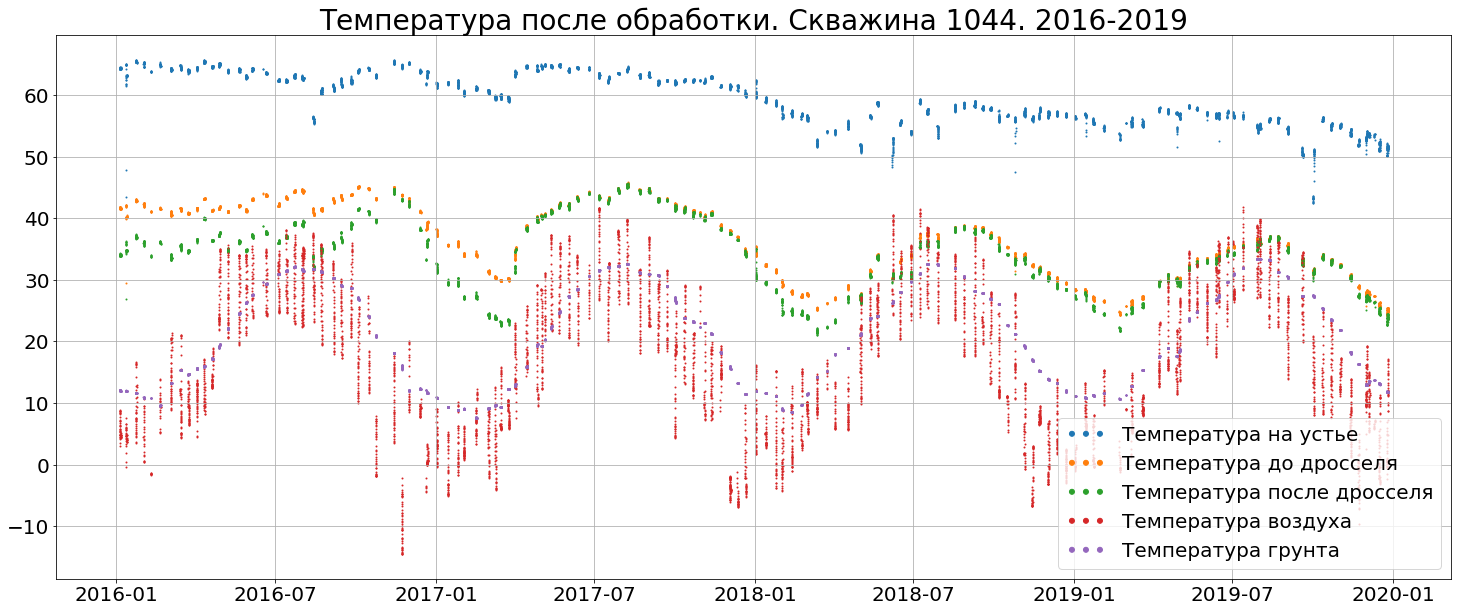

In [21]:
parameter1 = 'T1'
parameter2 = 'T2'
parameter3 = 'T3'
parameter4 = 'TA'
parameter5 = 'TG'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Температура на устье')
y = dfm[[parameter2]]
plt.scatter(x, y, s=1, label='Температура до дросселя')
y = dfm[[parameter3]]
plt.scatter(x, y, s=1, label='Температура после дросселя')
y = dfm[[parameter4]]
plt.scatter(x, y, s=1, label='Температура воздуха')
y = dfm[[parameter5]]
plt.scatter(x, y, s=1, label='Температура грунта')
plt.title('Температура после обработки. Скважина ' + wn + '. 2016-2019', fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/after_start_' + wn + '_temp.jpeg', dpi=300)

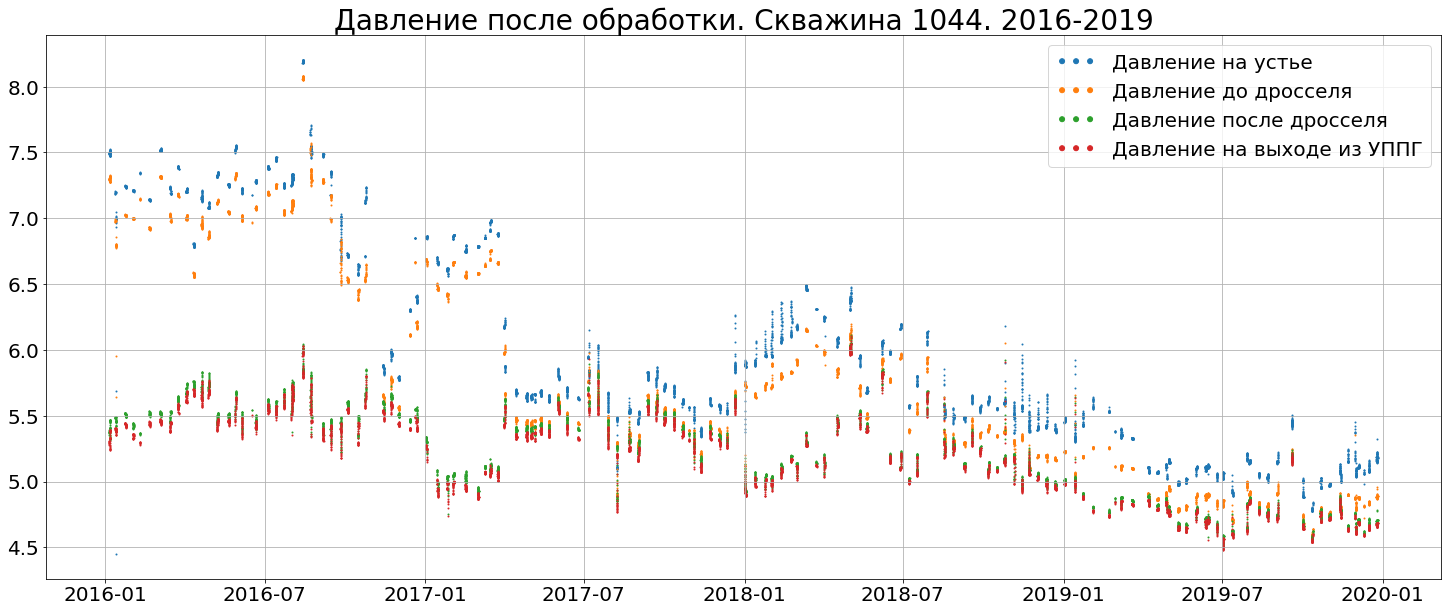

In [22]:
parameter1 = 'P1'
parameter2 = 'P2'
parameter3 = 'P3'
parameter4 = 'PO'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Давление на устье')
y = dfm[[parameter2]]
plt.scatter(x, y, s=1, label='Давление до дросселя')
y = dfm[[parameter3]]
plt.scatter(x, y, s=1, label='Давление после дросселя')
y = dfm[[parameter4]]
plt.scatter(x, y, s=1, label='Давление на выходе из УППГ')
plt.title('Давление после обработки. Скважина ' + wn + '. 2016-2019', fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/after_start_' + wn + '_press.jpeg', dpi=300)

## Обработка дебита

In [23]:
%%time
df = pd.read_csv('data/FTG.txt',
                 sep='	',
                 header=None,
                 names=['date', 'QG', 'del'],
                 skiprows = 4,
                 index_col = 'date',
                 parse_dates = True)

Wall time: 10min 33s


In [24]:
del df['del']
df

,QG
date,
2016-12-31 23:58:50.896010,449432.4
2016-12-31 23:56:05.886000,449429.4
2016-12-31 23:52:35.886000,449428.5
2016-12-31 23:49:05.886000,449430.2
2016-12-31 23:44:50.879010,449429.8
...,...
2019-01-01 02:22:31.072010,109559.1
2019-01-01 01:52:31.078000,109551.9
2019-01-01 01:29:11.085010,109546.8


In [25]:
%%time
df['QG'] = pd.to_numeric(df['QG'], errors='coerce') # формат числа, все ошибки в NaNdf = pd.concat([dfa, df])
df = pd.concat([dfa, df])
df.sort_index(inplace=True)
df.interpolate(method='time', limit=4, inplace=True) # интерполируем inplace методом time с лимитом в 4 пропуска
dfm['QG'] = "" # добавление столбца температуры
for row in df.itertuples(): # итерация по объединенному датафрейму
    if row[0] in dfm.index: # проверяем, есть ли индекс
        dfm.at[row[0], 'QG'] = row[1] # добавление новой записи в датафрейм dfm

Wall time: 1min 16s


In [26]:
dfm

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG
2016-01-05 10:30:00,7.498104,7.301981,5.388890,64.237796,41.667869,34.000999,2.984202,12.095092,5.311047,232515
2016-01-05 11:00:00,7.490100,7.292095,5.373202,64.252134,41.693662,33.901342,3.532487,12.095025,5.295226,232460
2016-01-05 11:30:00,7.498063,7.300164,5.379413,64.260998,41.741951,33.983417,4.731002,12.097428,5.301490,232666
2016-01-05 12:00:00,7.504444,7.309115,5.383830,64.269746,41.758143,34.089899,5.810583,12.092499,5.305113,232680
2016-01-05 12:30:00,7.491825,7.295716,5.377536,64.345201,41.742924,34.042069,6.232343,12.088733,5.298257,232647
...,...,...,...,...,...,...,...,...,...,...
2019-12-25 22:00:00,5.182087,4.895390,4.706744,51.328948,24.888187,23.710259,9.622903,11.742264,4.685236,82401.5
2019-12-25 22:30:00,5.180753,4.884416,4.703333,51.258910,24.783075,23.567153,8.719945,11.738842,4.683972,82371.1
2019-12-25 23:00:00,5.184203,4.889656,4.706904,51.298042,24.818470,23.580421,11.138139,11.734011,4.684455,82334
2019-12-25 23:30:00,5.179458,4.889208,4.709292,51.472662,24.848308,23.590241,12.109493,11.732719,4.684558,82297.4


In [27]:
dfm = dfm.astype(float)
dfm.describe()

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG
count,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6313.000000,6.291000e+03
mean,6.003531,5.784917,5.225657,59.387053,36.361689,34.014767,17.125698,21.001561,5.187409,1.615105e+05
std,0.814100,0.821269,0.345952,4.182732,5.883563,5.899185,11.828335,7.925186,0.338884,6.201924e+05
min,4.448729,4.584140,4.505248,42.526333,24.160022,21.103241,-14.542944,7.553524,4.482373,0.000000e+00
25%,5.410855,5.177933,4.951953,56.353090,31.306586,29.681288,7.645152,13.201756,4.911398,1.117636e+05
50%,5.707668,5.516687,5.264485,59.494078,36.628305,34.662841,16.574118,21.154000,5.228194,1.408659e+05
75%,6.747969,6.551302,5.499020,63.217768,41.686424,38.224791,27.093824,28.251950,5.443371,1.907860e+05
max,8.203495,8.083053,6.115540,65.748098,45.864090,45.752886,41.776329,33.428279,6.107847,4.884192e+07


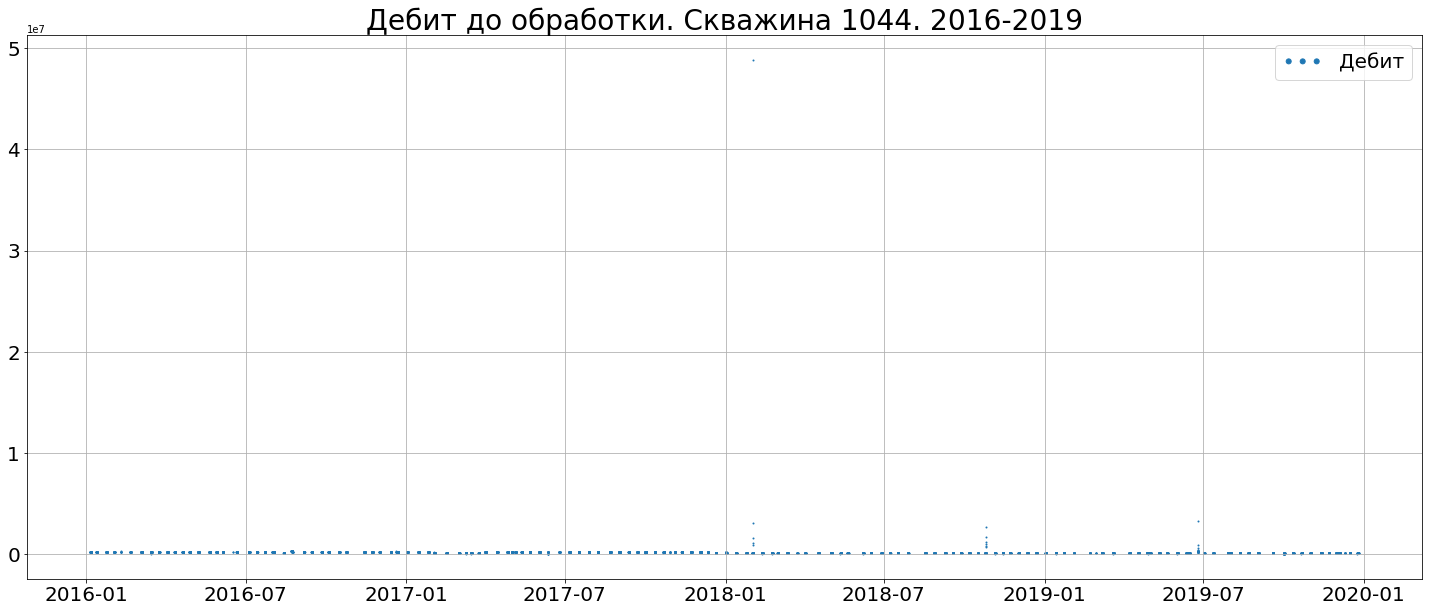

In [28]:
parameter1 = 'QG'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит до обработки. Скважина ' + wn + '. 2016-2019', fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/start_' + wn + '_flow_rate.jpeg', dpi=300)

In [29]:
# Диапазон значений для температуры на устье
dfm = dfm[~(dfm.QG > 300000)]
dfm = dfm[~(dfm.QG < 1000)]

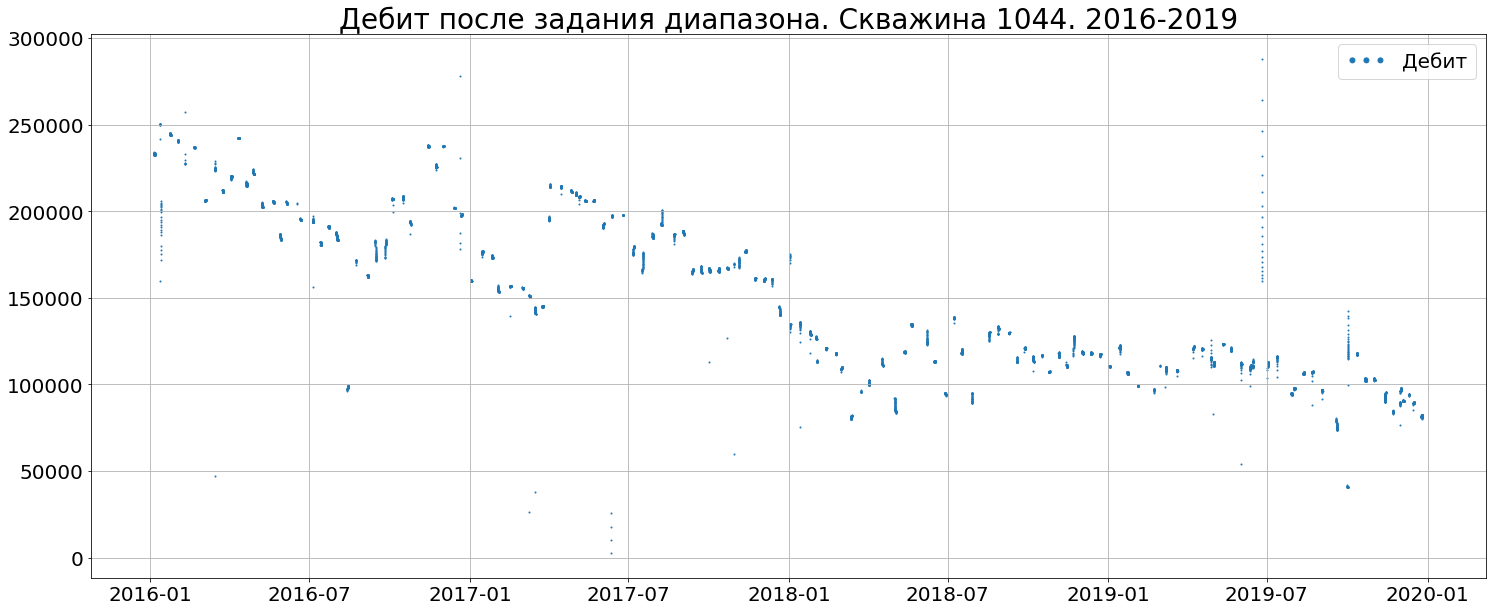

In [30]:
parameter1 = 'QG'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]].index
y = dfm[[parameter1]]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит после задания диапазона. Скважина ' + wn + '. 2016-2019', fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/range_' + wn + '_flow_rate.jpeg', dpi=300)

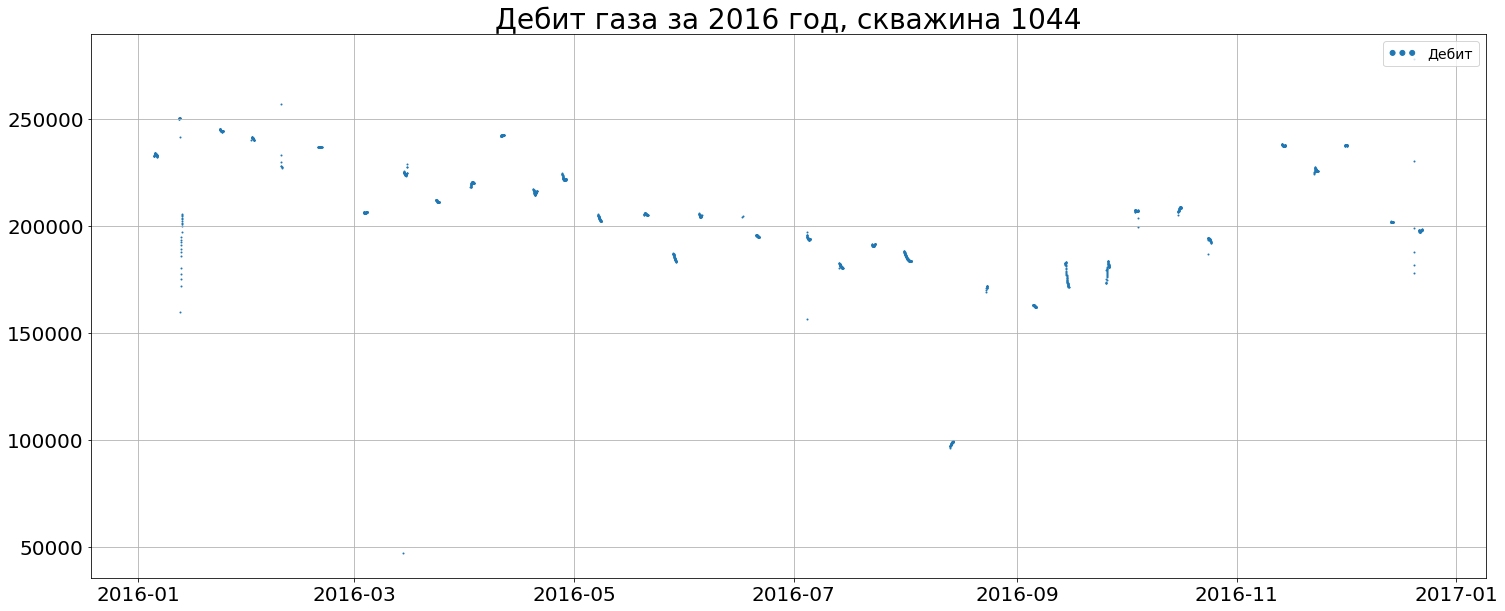

In [31]:
parameter1 = 'QG'
period = '2016'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]][period].index
y = dfm[[parameter1]][period]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит газа за 2016 год, скважина ' + wn, fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_' + wn + '_2016.jpeg', dpi=300)

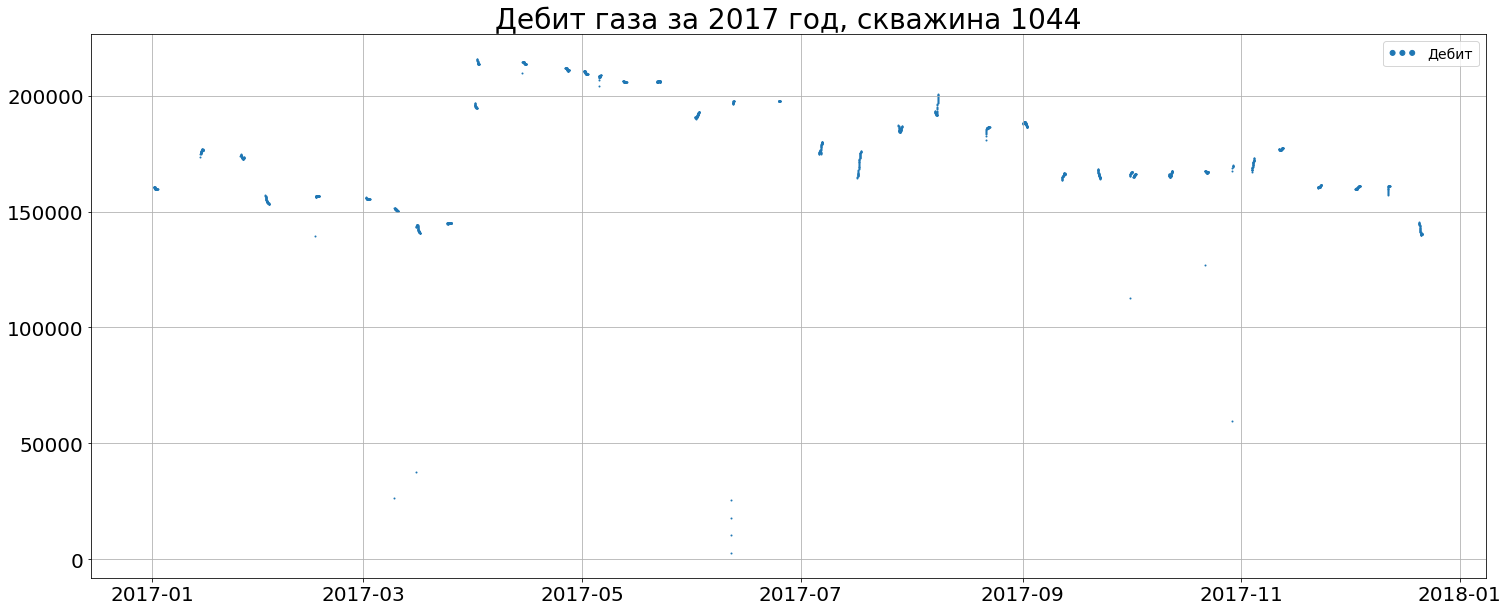

In [32]:
parameter1 = 'QG'
period = '2017'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]][period].index
y = dfm[[parameter1]][period]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит газа за 2017 год, скважина ' + wn, fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_' + wn + '_2017.jpeg', dpi=300)

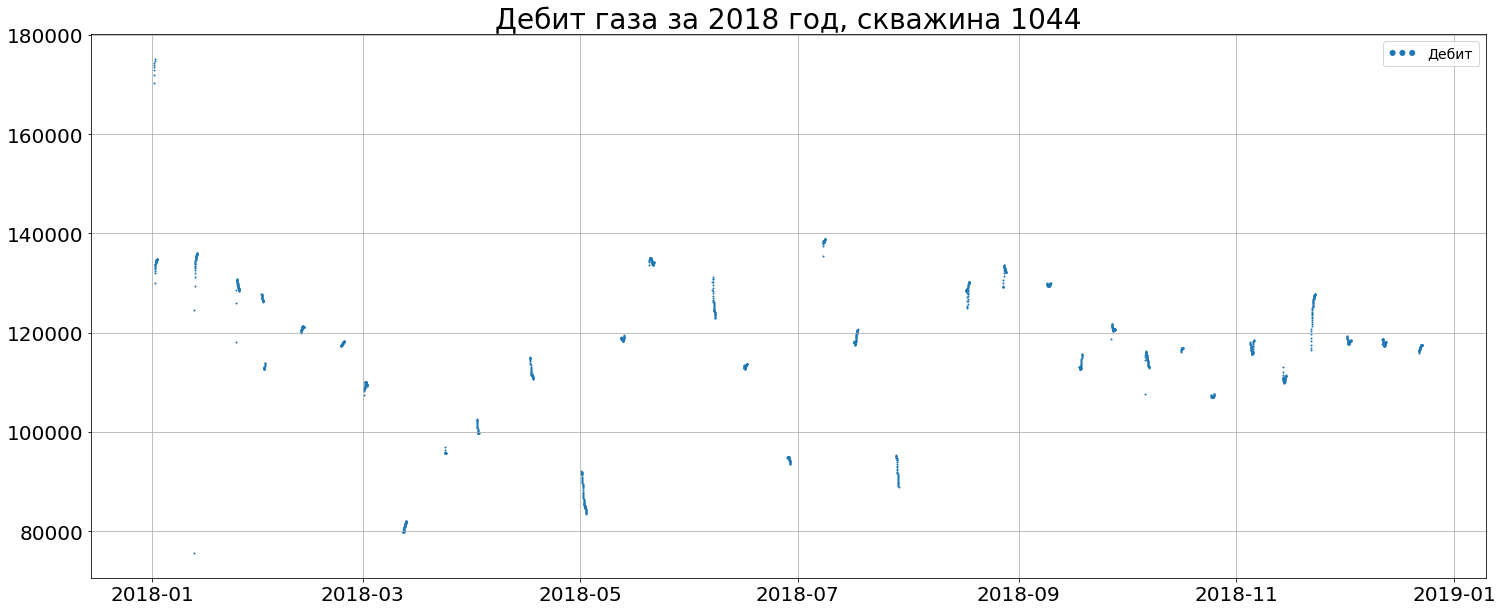

In [33]:
parameter1 = 'QG'
period = '2018'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]][period].index
y = dfm[[parameter1]][period]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит газа за 2018 год, скважина ' + wn, fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_' + wn + '_2018.jpeg', dpi=300)

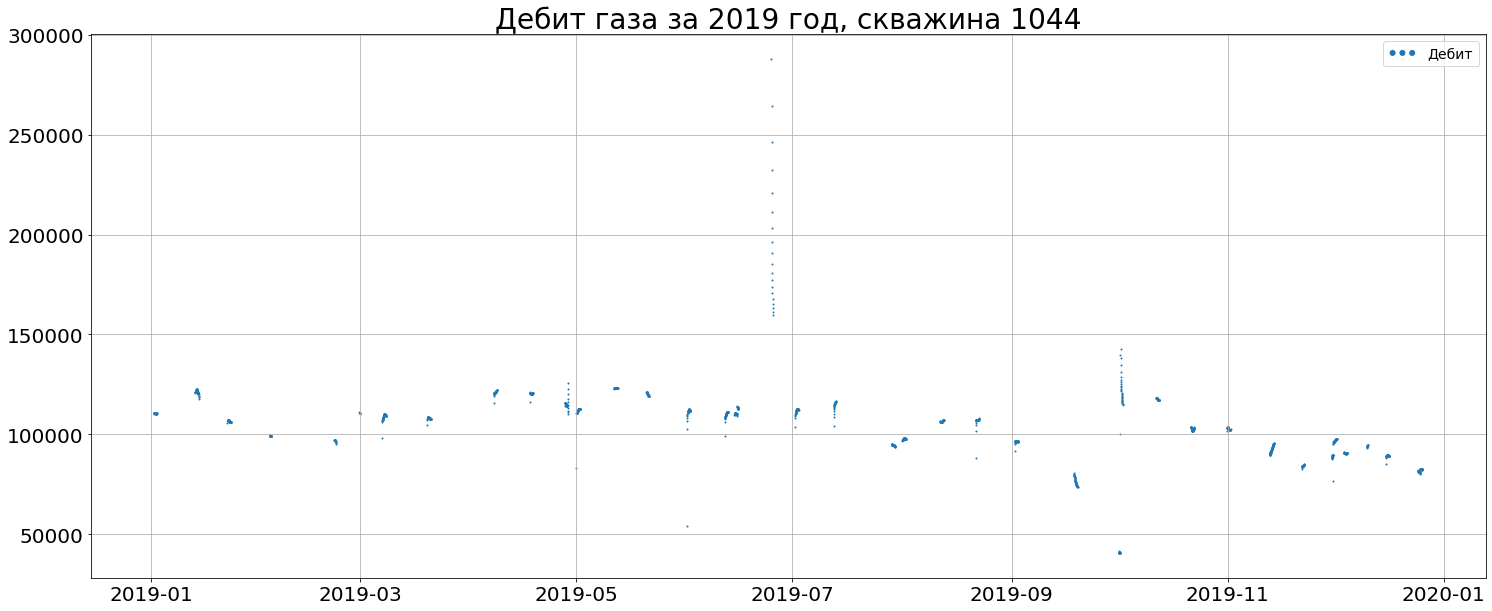

In [34]:
parameter1 = 'QG'
period = '2019'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dfm[[parameter1]][period].index
y = dfm[[parameter1]][period]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Дебит газа за 2019 год, скважина ' + wn, fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_' + wn + '_2019.jpeg', dpi=300)

In [35]:
dfm['QG'].isnull().sum()

22

In [36]:
dfm = dfm.dropna() # удаляем пропуски в данных

In [37]:
dfm

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG
2016-01-05 10:30:00,7.498104,7.301981,5.388890,64.237796,41.667869,34.000999,2.984202,12.095092,5.311047,232515.005721
2016-01-05 11:00:00,7.490100,7.292095,5.373202,64.252134,41.693662,33.901342,3.532487,12.095025,5.295226,232459.555648
2016-01-05 11:30:00,7.498063,7.300164,5.379413,64.260998,41.741951,33.983417,4.731002,12.097428,5.301490,232665.798852
2016-01-05 12:00:00,7.504444,7.309115,5.383830,64.269746,41.758143,34.089899,5.810583,12.092499,5.305113,232680.430678
2016-01-05 12:30:00,7.491825,7.295716,5.377536,64.345201,41.742924,34.042069,6.232343,12.088733,5.298257,232647.452201
...,...,...,...,...,...,...,...,...,...,...
2019-12-25 22:00:00,5.182087,4.895390,4.706744,51.328948,24.888187,23.710259,9.622903,11.742264,4.685236,82401.510593
2019-12-25 22:30:00,5.180753,4.884416,4.703333,51.258910,24.783075,23.567153,8.719945,11.738842,4.683972,82371.066945
2019-12-25 23:00:00,5.184203,4.889656,4.706904,51.298042,24.818470,23.580421,11.138139,11.734011,4.684455,82333.969454
2019-12-25 23:30:00,5.179458,4.889208,4.709292,51.472662,24.848308,23.590241,12.109493,11.732719,4.684558,82297.404073


In [38]:
dfm.to_csv('data/result_1.csv')

In [39]:
dft = dfm['QG'].copy()

In [40]:
df = pd.DataFrame(dft)

In [41]:
df = df.assign(proc = df.rolling(window=100, center=True).mean())
df = df.assign(mm = abs(1 - df.proc / df.QG))

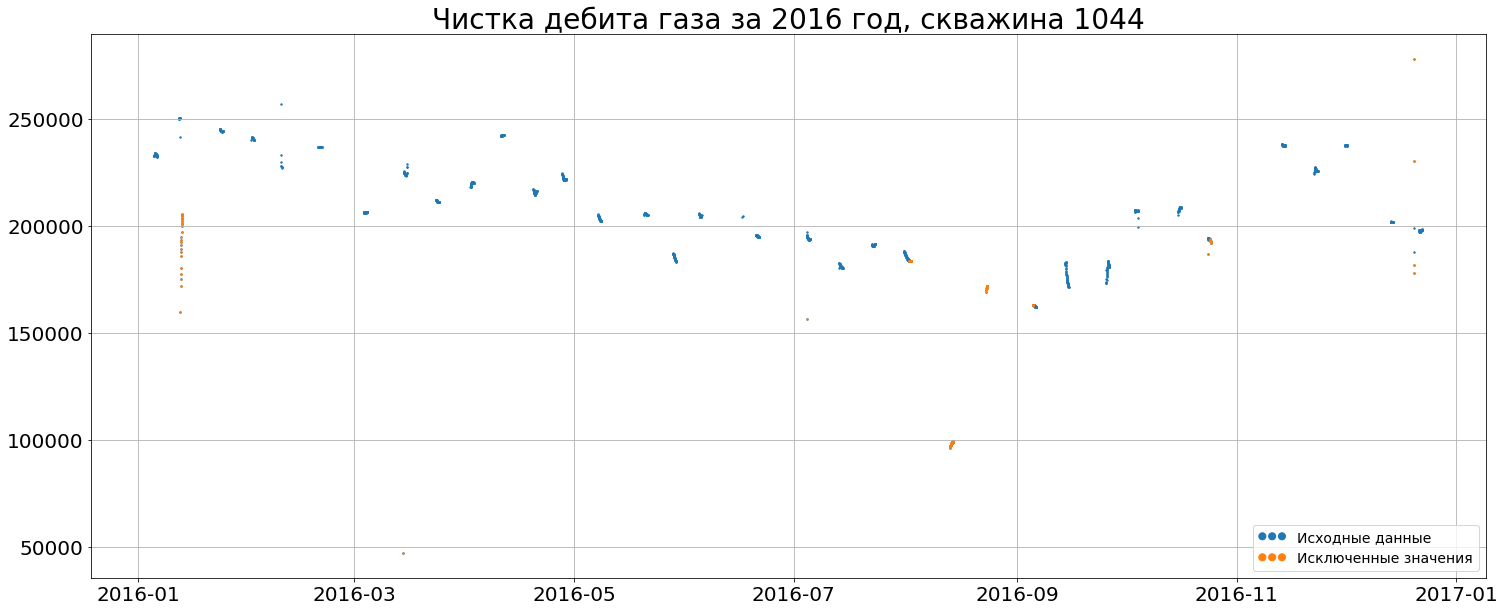

In [44]:
period = '2016'
k = 0.1
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dft[period].index
y = dft[period]
plt.scatter(x, y, s=2, label='Исходные данные')

x = df[df.mm > k][period].index
y = df[df.mm > k][period].QG
plt.scatter(x, y, s=2, label='Исключенные значения')

plt.title('Чистка дебита газа за 2016 год, скважина ' + wn, fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_clean' + wn + '_2016.jpeg', dpi=300)

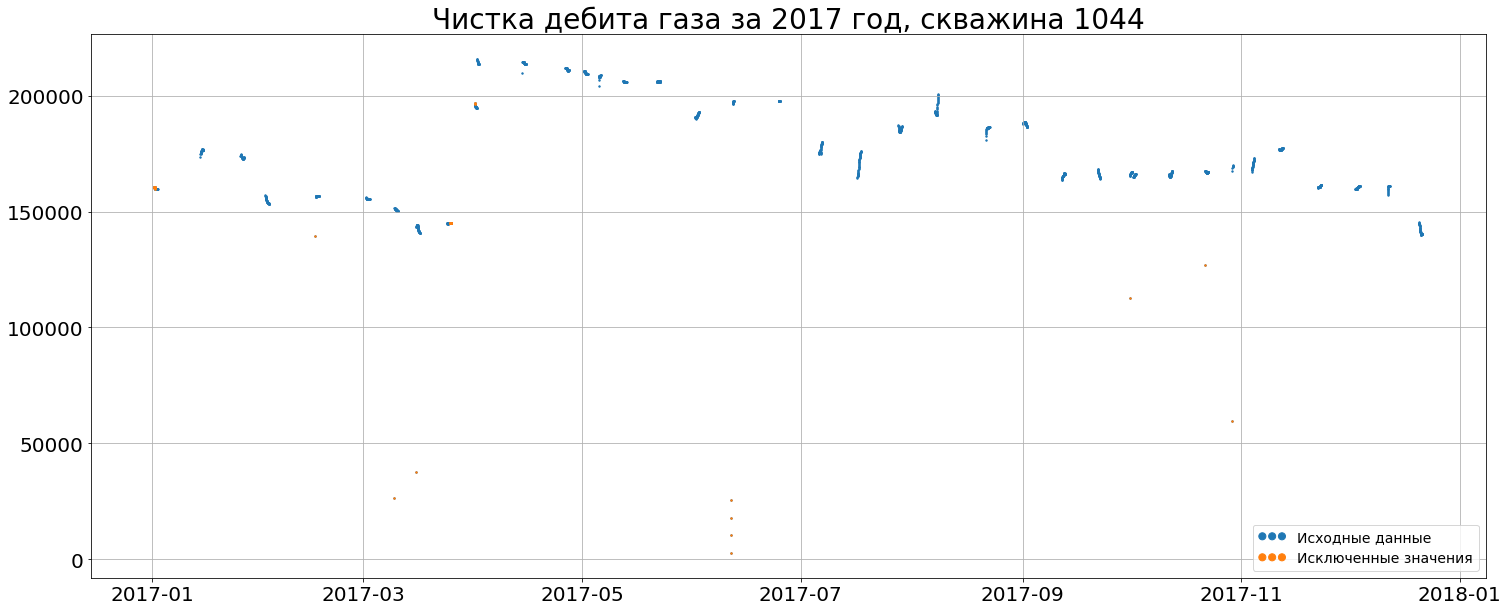

In [45]:
period = '2017'
k = 0.1
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dft[period].index
y = dft[period]
plt.scatter(x, y, s=2, label='Исходные данные')

x = df[df.mm > k][period].index
y = df[df.mm > k][period].QG
plt.scatter(x, y, s=2, label='Исключенные значения')

plt.title('Чистка дебита газа за 2017 год, скважина ' + wn, fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_clean' + wn + '_2017.jpeg', dpi=300)

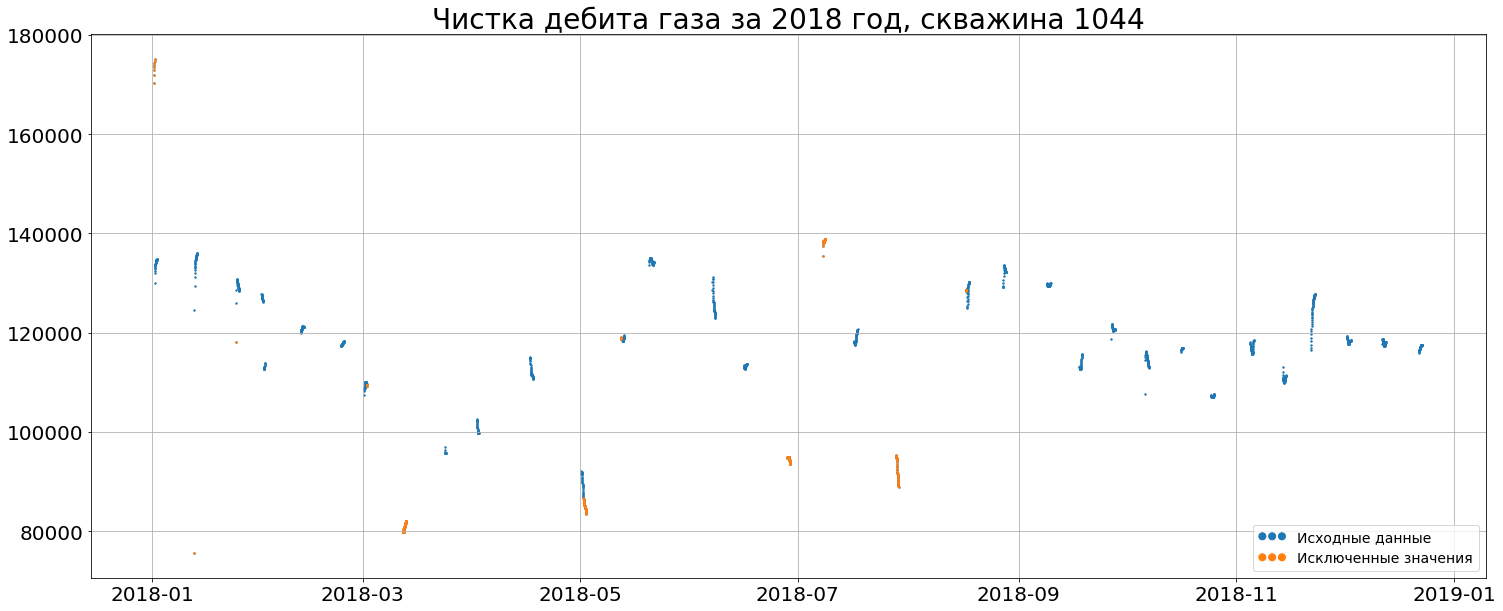

In [46]:
period = '2018'
k = 0.1
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dft[period].index
y = dft[period]
plt.scatter(x, y, s=2, label='Исходные данные')

x = df[df.mm > k][period].index
y = df[df.mm > k][period].QG
plt.scatter(x, y, s=2, label='Исключенные значения')

plt.title('Чистка дебита газа за 2018 год, скважина ' + wn, fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_clean' + wn + '_2018.jpeg', dpi=300)

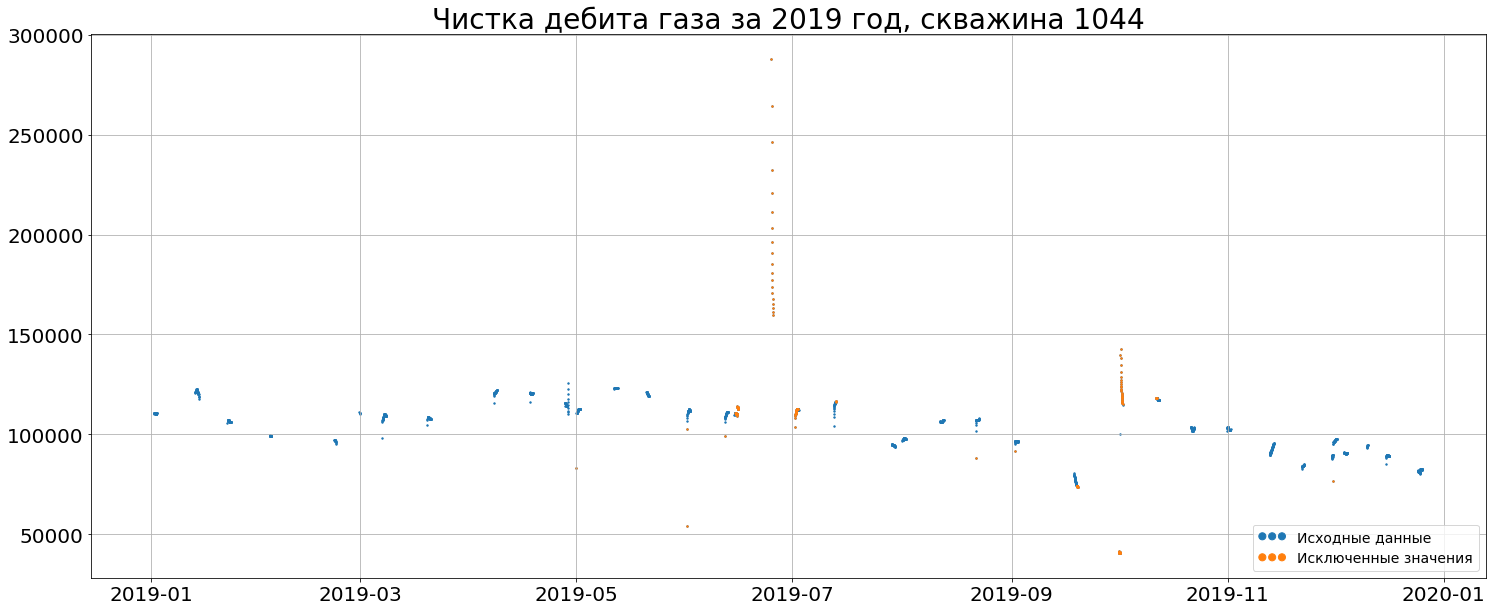

In [47]:
period = '2019'
k = 0.1
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = dft[period].index
y = dft[period]
plt.scatter(x, y, s=2, label='Исходные данные')

x = df[df.mm > k][period].index
y = df[df.mm > k][period].QG
plt.scatter(x, y, s=2, label='Исключенные значения')

plt.title('Чистка дебита газа за 2019 год, скважина ' + wn, fontsize=28)
plt.legend(loc='lower right', scatterpoints=3, fontsize=14, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/flow_rate_clean' + wn + '_2019.jpeg', dpi=300)

In [48]:
dft.isnull().sum()

0

In [49]:
df.mm

2016-01-05 10:30:00   NaN
2016-01-05 11:00:00   NaN
2016-01-05 11:30:00   NaN
2016-01-05 12:00:00   NaN
2016-01-05 12:30:00   NaN
                       ..
2019-12-25 22:00:00   NaN
2019-12-25 22:30:00   NaN
2019-12-25 23:00:00   NaN
2019-12-25 23:30:00   NaN
2019-12-26 00:00:00   NaN
Name: mm, Length: 6211, dtype: float64

In [50]:
dfm['proc'] = df.mm

In [51]:
dfm['2017']

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG,proc
2017-01-01 13:30:00,6.851431,6.691497,5.324193,62.167776,38.348769,32.699701,6.986432,10.900124,5.267476,159988.501767,0.117766
2017-01-01 14:00:00,6.852543,6.692104,5.328341,61.931117,38.315062,32.671887,7.967024,10.899085,5.266429,160406.659938,0.113373
2017-01-01 14:30:00,6.853880,6.692606,5.331593,61.914265,38.242649,32.626241,8.984868,10.903154,5.268991,160438.646159,0.112385
2017-01-01 15:00:00,6.855377,6.693391,5.334588,61.924545,38.217917,32.597833,9.007565,10.899823,5.270844,160436.671275,0.112005
2017-01-01 15:30:00,6.856112,6.692978,5.333876,62.057126,38.193090,32.593833,8.971017,10.896704,5.270462,160429.881178,0.111893
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21 10:30:00,5.892639,5.632547,5.599365,60.230723,34.443001,34.026642,-0.425690,11.440189,5.568544,140306.315706,0.014672
2017-12-21 11:00:00,5.900800,5.631958,5.600073,60.371141,34.532366,34.165219,1.976385,11.441007,5.566563,140319.562790,0.012550
2017-12-21 11:30:00,5.901166,5.628622,5.601941,60.331690,34.658104,34.348748,3.774908,11.440328,5.563793,140349.693827,0.010336
2017-12-21 12:00:00,5.910313,5.626479,5.601362,60.289904,34.749886,34.417542,4.092547,11.439882,5.560454,140386.687701,0.008096


In [53]:
dfm.to_csv('data/result_2.csv')

In [54]:
%%time
df = pd.read_csv('data/result_2.csv',
                 header = 0,
                 index_col = 0,
                 parse_dates = True)

Wall time: 90 ms


# df

In [55]:
df_new = df[~(df.proc > 0.1)]

In [57]:
df_new

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG,proc
2016-01-05 10:30:00,7.498104,7.301981,5.388890,64.237796,41.667869,34.000999,2.984202,12.095092,5.311047,232515.005721,NaN
2016-01-05 11:00:00,7.490100,7.292095,5.373202,64.252134,41.693662,33.901342,3.532487,12.095025,5.295226,232459.555648,NaN
2016-01-05 11:30:00,7.498063,7.300164,5.379413,64.260998,41.741951,33.983417,4.731002,12.097428,5.301490,232665.798852,NaN
2016-01-05 12:00:00,7.504444,7.309115,5.383830,64.269746,41.758143,34.089899,5.810583,12.092499,5.305113,232680.430678,NaN
2016-01-05 12:30:00,7.491825,7.295716,5.377536,64.345201,41.742924,34.042069,6.232343,12.088733,5.298257,232647.452201,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 22:00:00,5.182087,4.895390,4.706744,51.328948,24.888187,23.710259,9.622903,11.742264,4.685236,82401.510593,NaN
2019-12-25 22:30:00,5.180753,4.884416,4.703333,51.258910,24.783075,23.567153,8.719945,11.738842,4.683972,82371.066945,NaN
2019-12-25 23:00:00,5.184203,4.889656,4.706904,51.298042,24.818470,23.580421,11.138139,11.734011,4.684455,82333.969454,NaN
2019-12-25 23:30:00,5.179458,4.889208,4.709292,51.472662,24.848308,23.590241,12.109493,11.732719,4.684558,82297.404073,NaN


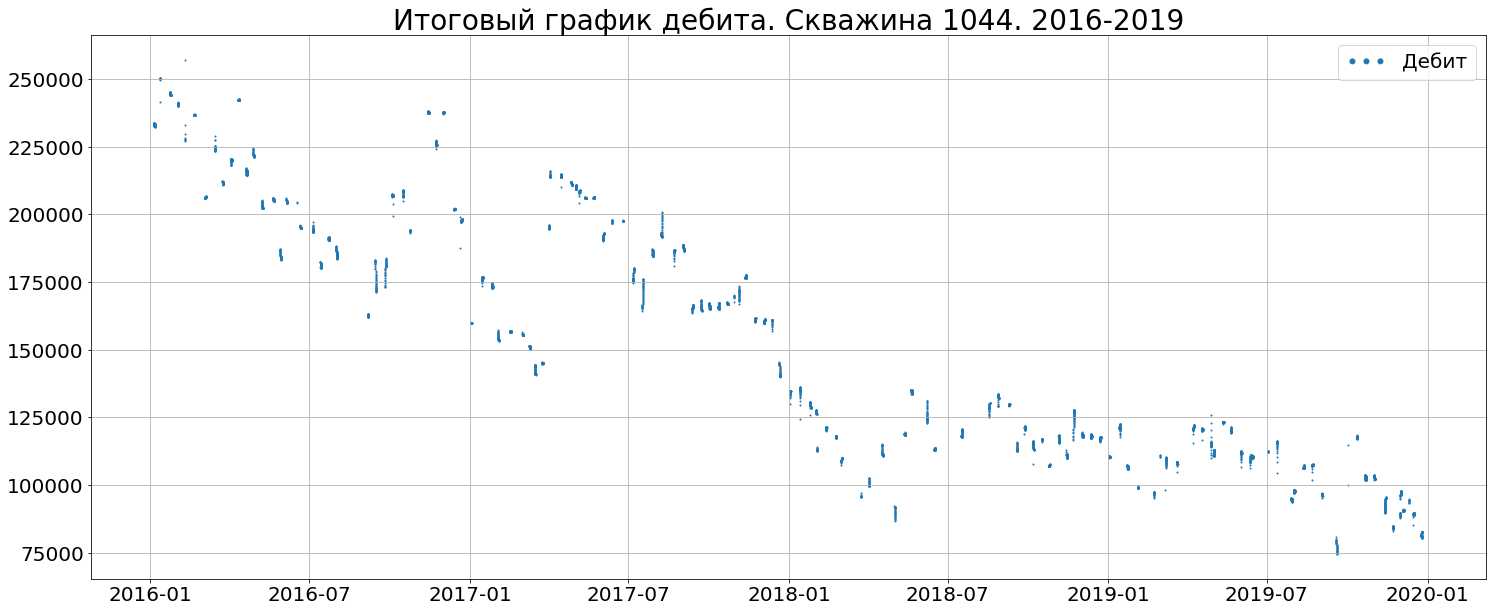

In [58]:
parameter1 = 'QG'
plt.figure(figsize=(25, 10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
x = df_new[[parameter1]].index
y = df_new[[parameter1]]
plt.scatter(x, y, s=1, label='Дебит')
plt.title('Итоговый график дебита. Скважина ' + wn + '. 2016-2019', fontsize=28)
plt.legend(loc='upper right', scatterpoints=3, fontsize=20, markerscale=5, scatteryoffsets=[0.5])
plt.savefig('pictures/final_' + wn + '_flow_rate.jpeg', dpi=300)

In [59]:
del df_new['proc']

In [60]:
df_new.to_csv('data/result_3.csv')

In [61]:
df_new

,P1,P2,P3,T1,T2,T3,TA,TG,PO,QG
2016-01-05 10:30:00,7.498104,7.301981,5.388890,64.237796,41.667869,34.000999,2.984202,12.095092,5.311047,232515.005721
2016-01-05 11:00:00,7.490100,7.292095,5.373202,64.252134,41.693662,33.901342,3.532487,12.095025,5.295226,232459.555648
2016-01-05 11:30:00,7.498063,7.300164,5.379413,64.260998,41.741951,33.983417,4.731002,12.097428,5.301490,232665.798852
2016-01-05 12:00:00,7.504444,7.309115,5.383830,64.269746,41.758143,34.089899,5.810583,12.092499,5.305113,232680.430678
2016-01-05 12:30:00,7.491825,7.295716,5.377536,64.345201,41.742924,34.042069,6.232343,12.088733,5.298257,232647.452201
...,...,...,...,...,...,...,...,...,...,...
2019-12-25 22:00:00,5.182087,4.895390,4.706744,51.328948,24.888187,23.710259,9.622903,11.742264,4.685236,82401.510593
2019-12-25 22:30:00,5.180753,4.884416,4.703333,51.258910,24.783075,23.567153,8.719945,11.738842,4.683972,82371.066945
2019-12-25 23:00:00,5.184203,4.889656,4.706904,51.298042,24.818470,23.580421,11.138139,11.734011,4.684455,82333.969454
2019-12-25 23:30:00,5.179458,4.889208,4.709292,51.472662,24.848308,23.590241,12.109493,11.732719,4.684558,82297.404073
